In [1]:
import wandb
from datetime import datetime

In [2]:
lr = 1e-4
batch_size = 2
wd = 1e-5
image_size = 256
backbone="none"
vertical_type = "axial"
train_portion = 0.5
milestones = [50, 100, 150, 200]
model_name = "effdet"


In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms

# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold

IMAGE_SIZE = 512

# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95')

In [5]:
df = pd.read_csv(os.path.join(DATA_DIR, 'bbox_clean.csv')).set_index('StudyInstanceUID')
print(len(df))
df.head()

7203


,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
StudyInstanceUID,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [6]:
boundary_df = pd.read_csv(os.path.join(DATA_DIR, 'train_axial_boundary.csv')).set_index('UID')
print(len(boundary_df))
boundary_df.head()

2012


,aspect,xmin,ymin,xmax,ymax
UID,,,,,
1.2.826.0.1.3680043.10001,2.461541,78.849180,47.024193,453.30298,420.97748
1.2.826.0.1.3680043.10005,2.091504,93.988910,63.075333,373.98172,460.40836
1.2.826.0.1.3680043.10014,3.418803,22.234573,11.231842,500.32007,506.54834
1.2.826.0.1.3680043.10016,1.136566,73.564575,27.175400,444.91382,438.84436
1.2.826.0.1.3680043.10032,1.951216,85.200000,30.145882,420.28073,443.24400


In [7]:
for i in range(len(boundary_df)):
    boundary = boundary_df.iloc[i]
    df.loc[boundary.name, ['xmin','ymin','xmax','ymax']] = boundary[['xmin','ymin','xmax','ymax']].values
df.head()

,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number,xmin,ymin,xmax,ymax
StudyInstanceUID,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1.0,132.0,226.0,227.0,2.461541,0.253906,0.625,0.0,272.0,219.27715,216.71419,17.30440,20.38517,133.0,36.93093,40.741394,430.5001,422.72394
1.2.826.0.1.3680043.10051,1.0,133.0,229.0,230.0,2.461541,0.253906,0.625,0.0,272.0,221.56460,216.71419,17.87844,25.24362,134.0,36.93093,40.741394,430.5001,422.72394
1.2.826.0.1.3680043.10051,1.0,134.0,234.0,230.0,2.461541,0.253906,0.625,0.0,272.0,216.82151,221.62546,27.00959,26.37454,135.0,36.93093,40.741394,430.5001,422.72394
1.2.826.0.1.3680043.10051,1.0,135.0,234.0,228.0,2.461541,0.253906,0.625,0.0,272.0,214.49455,215.48637,27.92726,37.51363,136.0,36.93093,40.741394,430.5001,422.72394
1.2.826.0.1.3680043.10051,1.0,136.0,237.0,227.0,2.461541,0.253906,0.625,0.0,272.0,214.00000,215.48637,27.00000,43.51363,137.0,36.93093,40.741394,430.5001,422.72394


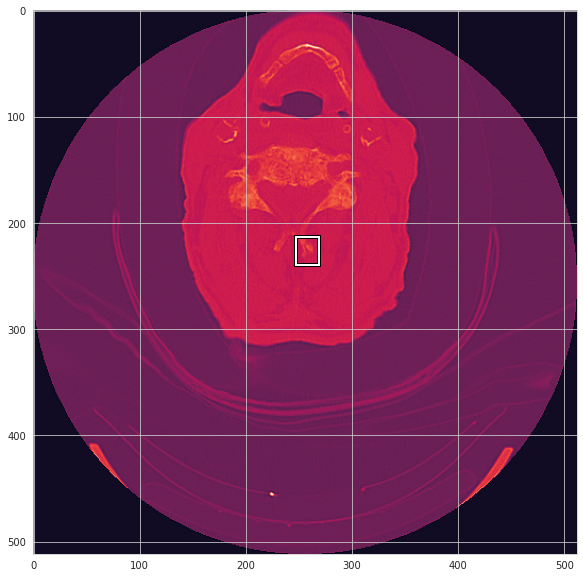

In [23]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height


def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)


def show_image(
        image, bbox=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    draw_bboxes_fn(ax, bbox)

    plt.show()


s = df.iloc[370]
image = Image.open(os.path.join(IMAGES_DIR, s.name, f'{int(s.axial_index)}.jpeg'))
bboxes = list(s[['x', 'y','width','height']])
show_image(image, [bboxes[0], bboxes[1], bboxes[0] + bboxes[2], bboxes[1] + bboxes[3]])